In [1]:
import pandas as pd
from evalml import AutoMLSearch
from evalml.preprocessing import split_data
from evalml.problem_types import ProblemTypes
from evalml.objectives.utils import get_optimization_objectives
from sklearn.metrics import classification_report

In [2]:
import torch

# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

# Move tensores/modelos para a GPU
tensor_cpu = torch.tensor([1.0, 2.0, 3.0])
tensor_gpu = tensor_cpu.to(device)  # Movendo para GPU

# Modelos também precisam ser movidos
model = torch.nn.Linear(3, 1).to(device)
output = model(tensor_gpu)  # Executa na GPU

Usando: cuda


base = pd.read_excel("../../Bases/Base_plano_Cartesiano.xlsx")
base.drop(columns=['V0024', 'UPA_PNS', 'V0006_PNS', 'C00301', 'C004', 'L01701', 'L018', 'M01601', 'Q11006'], inplace=True)

In [3]:
base = pd.read_excel("../../Bases/Base_plano_Cartesiano.xlsx")

### Treino e teste

In [4]:
X_prev = base.drop(columns=['Q074'])
y_classe = base['Q074']

In [5]:
X_train, X_test, y_train, y_test = split_data(X_prev, y_classe, problem_type='binary', test_size=0.3, random_seed=42)

/home/arthur/.local/lib/python3.12/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/home/arthur/.local/lib/python3.12/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


## AutoML

In [6]:
problem_type = ProblemTypes.BINARY 

In [7]:
print("Métricas permitidas para otimização:")
print([obj.name for obj in get_optimization_objectives('binary')])

Métricas permitidas para otimização:
['MCC Binary', 'Log Loss Binary', 'Gini', 'AUC', 'Precision', 'F1', 'Balanced Accuracy Binary', 'Accuracy Binary']


In [ ]:
automl = AutoMLSearch(
    X_train=X_train, 
    y_train=y_train,
    problem_type=problem_type,
    objective='log loss binary',  
    max_batches=25,
    n_jobs=-1,
    ensembling=True,
    sampler_method= 'Undersampler',
    random_seed=42
)

In [9]:
automl.search()

{1: {'Random Forest Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Undersampler + RF Classifier Select From Model': 2.267125368118286,
  'Total time of batch': 2.3790438175201416},
 2: {'LightGBM Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Undersampler + Select Columns Transformer': 1.8384549617767334,
  'Extra Trees Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Undersampler + Select Columns Transformer': 1.543156385421753,
  'Elastic Net Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Undersampler + Standard Scaler + Select Columns Transformer': 1.7303574085235596,
  'XGBoost Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Undersampler + Select Columns Transformer': 1.2922537326812744,
  'Logistic Regression Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Unde

### Resultados

In [10]:
automl.rankings

,id,pipeline_name,search_order,ranking_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,14,Logistic Regression Classifier w/ Label Encode...,14,0.281307,0.281307,0.001708,84.808998,False,"{'Label Encoder': {'positive_label': None}, 'D..."
19,4,Elastic Net Classifier w/ Label Encoder + Drop...,4,0.281757,0.281757,0.001584,84.784688,False,"{'Label Encoder': {'positive_label': None}, 'D..."
21,15,Random Forest Classifier w/ Label Encoder + Dr...,15,0.282214,0.282214,0.001525,84.760031,False,"{'Label Encoder': {'positive_label': None}, 'D..."
28,46,Extra Trees Classifier w/ Label Encoder + Drop...,46,0.282615,0.282615,0.001522,84.738381,False,"{'Label Encoder': {'positive_label': None}, 'D..."
32,1,Random Forest Classifier w/ Label Encoder + Dr...,1,0.282719,0.282719,0.002207,84.732724,False,"{'Label Encoder': {'positive_label': None}, 'D..."
59,2,LightGBM Classifier w/ Label Encoder + Drop Co...,2,0.286970,0.286970,0.002175,84.503199,False,"{'Label Encoder': {'positive_label': None}, 'D..."
60,5,XGBoost Classifier w/ Label Encoder + Drop Col...,5,0.287932,0.287932,0.003314,84.451230,False,"{'Label Encoder': {'positive_label': None}, 'D..."
62,7,Stacked Ensemble Classification Pipeline,7,0.420410,0.420410,0.004145,77.297221,False,"{'Label Encoder': {'positive_label': None}, 'R..."
63,0,Mode Baseline Binary Classification Pipeline,0,1.851799,1.851799,0.002073,0.000000,False,"{'Label Encoder': {'positive_label': None}, 'B..."


In [11]:
best_pipeline = automl.best_pipeline
print("\nMelhor pipeline:", best_pipeline.name)
print("Parâmetros do melhor pipeline:", best_pipeline.parameters)


Melhor pipeline: Logistic Regression Classifier w/ Label Encoder + Drop Columns Transformer + Imputer + One Hot Encoder + Undersampler + Standard Scaler + Select Columns Transformer
Parâmetros do melhor pipeline: {'Label Encoder': {'positive_label': None}, 'Drop Columns Transformer': {'columns': ['L01701', 'L018']}, 'Imputer': {'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'most_frequent', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'One Hot Encoder': {'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': 'if_binary', 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'Undersampler': {'sampling_ratio': 0.25, 'min_samples': 100, 'min_percentage': 0.1, 'sampling_ratio_dict': None}, 'Select Columns Transformer': {'columns': ['V0001', 'V0024', 'UPA_PNS', 'V0006_PNS', 'V0022', 'A02201|A02305|A02306', 'C004', 'C008', 'M01601', 'N010', 'P00104', 'P00404', 

In [12]:
scores = best_pipeline.score(X_test, y_test, objectives=['log loss binary', 'f1', 'precision', 'recall'])
print("\nDesempenho no conjunto de teste:")
print(scores)


Desempenho no conjunto de teste:
OrderedDict({'Log Loss Binary': 0.2802360609799926, 'F1': 0.9732871531510012, 'Precision': 0.9492894307680361, 'Recall': 0.9985296520176442})


In [13]:
predictions = best_pipeline.predict(X_test)
predict_proba = best_pipeline.predict_proba(X_test)

In [14]:
print("\nRelatório de Classificação por Classe:")
print(classification_report(y_test, predictions, target_names=['Nao tem asma', 'tem asma']))


Relatório de Classificação por Classe:
              precision    recall  f1-score   support

Nao tem asma       0.36      0.02      0.03       663
    tem asma       0.95      1.00      0.97     12242

    accuracy                           0.95     12905
   macro avg       0.65      0.51      0.50     12905
weighted avg       0.92      0.95      0.92     12905



In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Primeiro, vamos identificar quais são os rótulos únicos presentes nos dados
unique_labels = sorted(y_test.unique())
print(f"Rótulos encontrados: {unique_labels}")

# Agora vamos calcular as métricas usando os rótulos corretos
print("\nMétricas por classe:")
for label in unique_labels:
    print(f"\nClasse {label}:")
    print(f"Precisão: {precision_score(y_test, predictions, pos_label=label):.4f}")
    print(f"Recall: {recall_score(y_test, predictions, pos_label=label):.4f}")
    print(f"F1-Score: {f1_score(y_test, predictions, pos_label=label):.4f}")


Rótulos encontrados: [1, 2]

Métricas por classe:

Classe 1:
Precisão: 0.3571
Recall: 0.0151
F1-Score: 0.0289

Classe 2:
Precisão: 0.9493
Recall: 0.9985
F1-Score: 0.9733


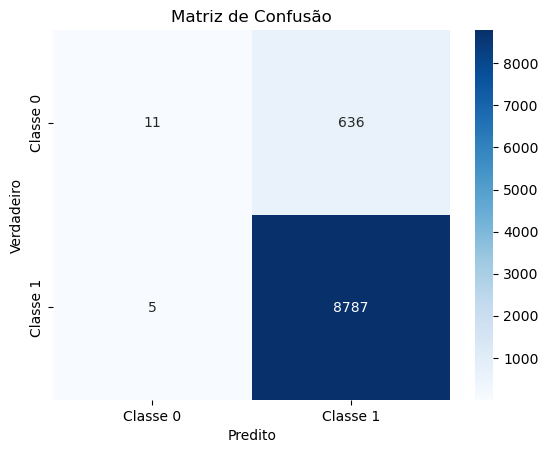

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()